# 样式迁移的原理

## 基本原理

`CNN`提取到的图片的特征表征不仅可以用于分类，还可用于构造图像
- `CNN`网络每层的图片过滤器依次处理输入的图片，提取出越来越复杂的特征；
- `max pooling`层将不断的丢弃空间上的细节信息，这些信息与分类任务相关性不大；
- 因此随着层次加深，提取出的特征图越来越关注内容，而不是纹理及颜色等细节信息
- `CNN`学习到了图片的**内容表征**；

如何提取风格/样式呢？
- 设计一个特征空间用来捕获图片的**纹理及颜色**等信息，
- 每个卷积层会输出多个特征图，这个特征空间会检查这些特征图间的相关性
    - 一个特征图中的颜色与另一特征图中的是否相似，
    - 如果特征图间有一些共同的颜色，可以看作是图片的“风格”

`style transfer`：将一张图片的风格运用到另一张图片上
![](../images/style_transfer.png)
上图所示，利用`vgg`模型实现样式迁移。内容图像经过`vgg`处理，得到内容特征，样式图像经过`vgg`处理得到样式特征，然后将两者融合

## 如何提取样式？

- `Gram Matrix`：每个卷积层会输出多个特征图，将每个特征图展平，然后求点积获得这些特征图两两之间的相似性
   
   
- `Gram Matrix`，可以表征图像的样式；不同图像，经过同一模型的同一卷积层时，输出的特征图差别可能很大，但`Gram Matrix`相近时，说明尽管图像内容相差很大，但肯定还存在内容之外的相似性

## 损失函数

样式迁移的目标**不再是训练模型**，而是找到最佳的目标图像，使得损失最小。
![](../images/neural-style.svg)

`Content Loss`：
- 训练开始时，会设置初始的**目标图像**，通常目标图像初始化与内容图像相同；
- 然后目标图像和内容图像经过同一个模型，获得各自的`content representation`
$$L_{content}=\frac{1}{2}\sum(T_c-C_c)^2$$
$T_c$表示目标图像的内容表征，$C_c$表示内容图像的内容表征。
    - 训练时冻结模型参数，不断更新目标图像
---

`Style Loss`:
- 在模型中选定几个卷积层，计算目标图像和样式图像在每个卷积层输出特征图的`Gram Matrix`，然后求两者间的`MSE`
    $$L_{style}=a\sum_{i}w_i(T_{s,i}-S_{s,i})^2$$
    其中$a$为常数，表征每层中值的数量；$T_{s,i}$表示目标图像经过第$i$个卷积层的`Gram Matrix`，$S_{s,i}$表示样式图像经过第$i$个卷积层的`Gram Matrix`，$w_i$表示第$i$个卷积层的权重
    
------
    
目标函数：
$$L=\alpha L_{content} + \beta L_{style}$$
通常设置$\frac{\alpha}{\beta}$的值，不同的值获得不同的图像，值越大保留越多的内容，值越小内容越少

In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

# 样式迁移的的实现
使用`vgg19`预训练模型实现，选择`conv4_2`输出作为内容特征，选择`conv1_1,conv2_1,conv3_1,conv4_1,conv5_1`卷积层的输出计算样式特征

## `vgg19`模型
包含5组卷积层，每组由多个卷积层堆叠而成，命名为`conv4_2`，表示第4组卷积堆中的第二个卷积层

In [2]:
# 预训练vgg模型的特征层，不包含最终用于分类的全连接层
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False) # 冻结参数

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device);

## 内容图像和样式图像

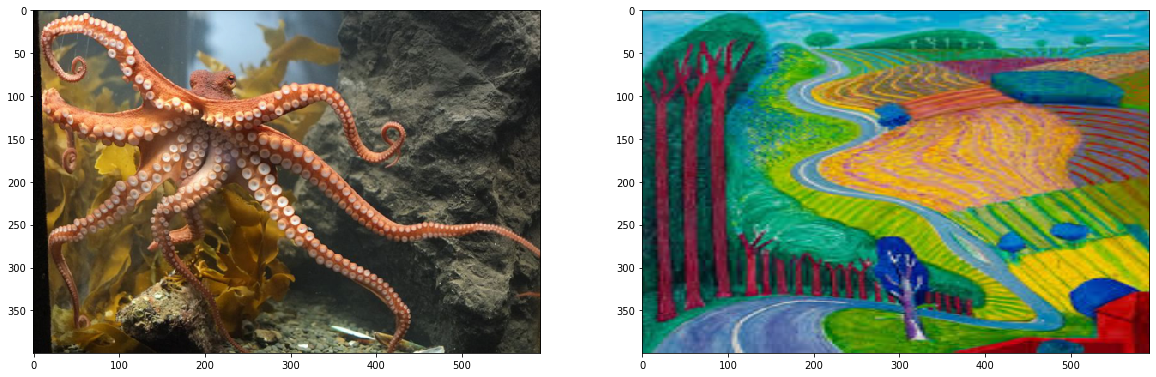

In [3]:
# 加载图像并预处理
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    # 图像预处理
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

# 内容图像
content = load_image('../images/octopus.jpg').to(device)

# 样式图像
style = load_image('../images/hockney.jpg', shape=content.shape[-2:]).to(device)


# 图像张量转换成数组，便于显示
def im_convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array(
        (0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

# 显示内容图像和样式图像
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## 抽取内容特征和样式特征

In [4]:
# 获取特定卷积层的输出

def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # 内容特征
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [5]:
# 内容图片的特征图
content_features = get_features(content, vgg)
content_features.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [6]:
# 样式图片的特征图
style_features = get_features(style, vgg)


# 计算样式图片特征图的Gram_matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


# 计算 Gram_matrix，抽取每层的样式特征
style_grams = {
    layer: gram_matrix(style_features[layer])
    for layer in style_features
}

In [7]:
# 不同层的样式特征的权重
style_weights = {
    'conv1_1': 1,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1
}

# 特征损失与内容损失的权重
content_weight = 1
style_weight = 1e6

## 进行训练

Total loss:  3087652.25


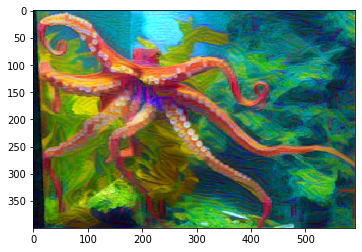

Total loss:  678061.0625


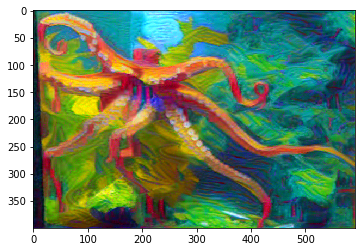

Total loss:  268899.125


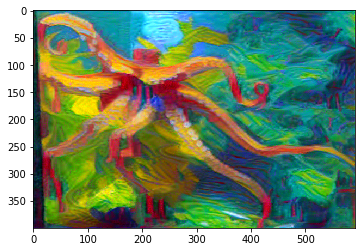

In [10]:
# 目标图像，复制内容图像
target = content.clone().requires_grad_(True).to(device)

show_every = 2000
optimizer = optim.Adam([target], lr=0.003)
steps = 6000

for ii in range(1, steps + 1):
    # 目标图像的特征输出
    target_features = get_features(target, vgg)
    
    ######conv4_2 层输出为内容表征，计算内容损失######################
    content_loss = torch.mean(
        (target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    ######各层的样式损失加权求和，计算总样式损失#######################
    style_loss = 0
    for layer in style_weights:
        # 目标图像的样式
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)

        _, d, h, w = target_feature.shape
        
        # 样式图像的样式
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean(
            (target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    ######总损失################################################
    total_loss = content_weight * content_loss + style_weight * style_loss

    # 更新图像
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # 显示训练中途的目标图像
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

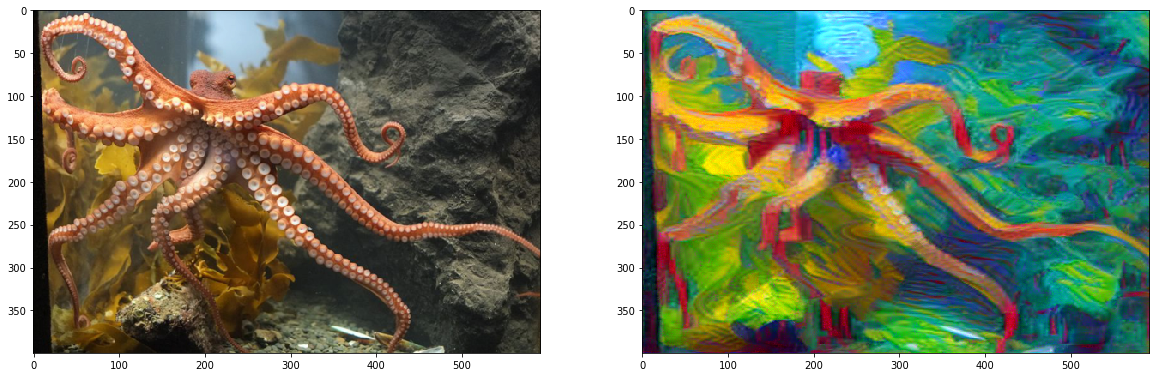

In [9]:
# 展示最终的结果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))